# Clustering Neighbourhoods in Toronto

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 94 kB 7.4 MB/s  eta 0:00:01
Libraries imported.


In [2]:
!pip install yellowbrick

     |████████████████████████████████| 271 kB 14.8 MB/s eta 0:00:01


In [3]:
!pip install geocoder

     |████████████████████████████████| 98 kB 9.6 MB/s  eta 0:00:01


### Importing Neighbourhoods from Wikipedia using Pandas read_html

In [4]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

In [5]:
df.head(5)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Filtering out if a Borough has 'Not assigned'

In [6]:
df = df[df.Borough != 'Not assigned']

In [7]:
df = df.reset_index(drop=True)

### Checking if there are any Neighbourhoods with 'Not assigned'

In [8]:
(df.Neighbourhood.str.contains('assigned')).sum()

0

In [9]:
df.shape

(103, 3)

## Q2

### Tried to import via Geocoder Package - but no luck. Used the provided file instead

In [10]:
df = df.merge(pd.read_csv('http://cocl.us/Geospatial_data'))

In [11]:
df= df[df.Borough.str.contains('Toronto')]
df = df.reset_index(drop=True)

In [12]:
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [13]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto City are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.


In [14]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Q3

#### Define Foursquare Credentials and Version


In [15]:
CLIENT_ID = '5KGOSG104PVEOSMCFU415AOVYU4URTXXTF3THPCIOBVEUEG4' # your Foursquare ID
CLIENT_SECRET = 'B3YL4YXJGIRBTP32WXQHYFI2CCM4NAHKVDK2NO1D5MKDDJ0I' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5KGOSG104PVEOSMCFU415AOVYU4URTXXTF3THPCIOBVEUEG4
CLIENT_SECRET:B3YL4YXJGIRBTP32WXQHYFI2CCM4NAHKVDK2NO1D5MKDDJ0I


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _toronto_venues_.


In [17]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])


Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

#### Let's check the size of the resulting dataframe


In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(1608, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


## 3. Analyze Each Neighborhood


In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronot_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"


And let's examine the new dataframe size.


In [20]:
toronto_onehot.shape

(1608, 229)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [21]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.062500
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.058824,0.058824,0.058824,0.117647,0.117647,0.117647,0.000000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.000000,0.00,0.015385,0.000000,0.000000,0.015385,0.015385
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.00,...,0.012987,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.025974
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.03125,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


#### Let's confirm the new size


In [22]:
toronto_grouped.shape

(39, 229)

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Restaurant,Seafood Restaurant,Beer Bar,Farmers Market,Greek Restaurant,Fish Market
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Pet Store,Furniture / Home Store,Burrito Place,Restaurant,Stadium,Italian Restaurant
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Restaurant,Burrito Place,Brewery,Skate Park,Farmers Market
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Boat or Ferry,Bar,Rental Car Location,Sculpture Garden,Coffee Shop,Plane
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Salad Place,Bubble Tea Shop,Portuguese Restaurant,Ramen Restaurant,Poke Place


<a id='item4'></a>


## 4. Cluster Neighborhoods


Check how many clusters that is optimal


In [25]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(toronto_grouped.drop('Neighbourhood', 1))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


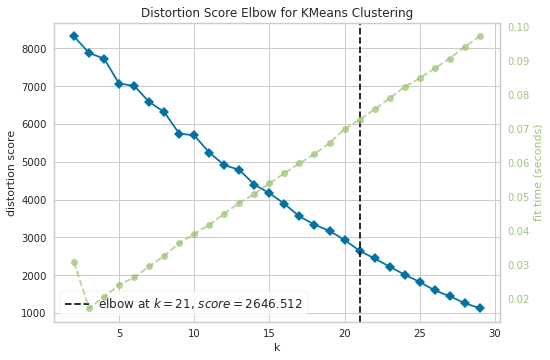

In [28]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(X)        # Fit data to visualizer
visualizer.show()

### small elbow @8 clusters --> will use that as K

In [29]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 4, 2, 1, 3, 2, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [30]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Restaurant,Pub,Breakfast Spot,Theater,Café,Electronics Store,Performing Arts Venue
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Fried Chicken Joint,Burger Joint,Burrito Place,Restaurant,Café,Smoothie Shop,Japanese Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Italian Restaurant,Cosmetics Shop,Bubble Tea Shop,Middle Eastern Restaurant,Café,Japanese Restaurant,Lingerie Store,Ramen Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gastropub,Department Store,Moroccan Restaurant,Lingerie Store,Clothing Store,Gym
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Neighborhood,Health Food Store,Trail,Pub,Yoga Studio,Dog Run,Diner,Discount Store,Distribution Center,Donut Shop


Finally, let's visualize the resulting clusters


In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


In [32]:
toronto_merged['Cluster Labels'].value_counts()

1    24
2     9
7     1
6     1
5     1
4     1
3     1
0     1
Name: Cluster Labels, dtype: int64

# Analysis

#### Seems like there are two main groups. I show below that Cluster 2 is more restaurant heavy whereas Cluster 1 is probably more residentially focused.

## 5. Examine Clusters


Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 0


In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,East Toronto,0,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Neighborhood


#### Cluster 1
Even though there are a lot of restaurants,  it feels more like a residential cluster with coffee shops, stores and yoga studios.


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Park,Bakery,Restaurant,Pub,Breakfast Spot,Theater,Café,Electronics Store,Performing Arts Venue
1,Downtown Toronto,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Fried Chicken Joint,Burger Joint,Burrito Place,Restaurant,Café,Smoothie Shop,Japanese Restaurant
2,Downtown Toronto,1,Coffee Shop,Clothing Store,Italian Restaurant,Cosmetics Shop,Bubble Tea Shop,Middle Eastern Restaurant,Café,Japanese Restaurant,Lingerie Store,Ramen Restaurant
4,East Toronto,1,Neighborhood,Health Food Store,Trail,Pub,Yoga Studio,Dog Run,Diner,Discount Store,Distribution Center,Donut Shop
7,Downtown Toronto,1,Grocery Store,Café,Park,Baby Store,Restaurant,Candy Store,Nightclub,Coffee Shop,Italian Restaurant,Donut Shop
9,West Toronto,1,Bakery,Pharmacy,Liquor Store,Recording Studio,Bank,Supermarket,Brewery,Middle Eastern Restaurant,Pool,Café
12,East Toronto,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bubble Tea Shop,Indian Restaurant,Spa,Juice Bar
14,West Toronto,1,Café,Breakfast Spot,Nightclub,Coffee Shop,Pet Store,Furniture / Home Store,Burrito Place,Restaurant,Stadium,Italian Restaurant
15,East Toronto,1,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Movie Theater,Italian Restaurant,Fish & Chips Shop,Brewery,Ice Cream Shop,Pub,Restaurant
18,Central Toronto,1,Park,Construction & Landscaping,Bus Line,Swim School,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 2
Looks like there's mostly restaurants, bars and pubs in this cluster.


In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Downtown Toronto,2,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gastropub,Department Store,Moroccan Restaurant,Lingerie Store,Clothing Store,Gym
5,Downtown Toronto,2,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Restaurant,Seafood Restaurant,Beer Bar,Farmers Market,Greek Restaurant,Fish Market
6,Downtown Toronto,2,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Salad Place,Bubble Tea Shop,Portuguese Restaurant,Ramen Restaurant,Poke Place
8,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Gym,Clothing Store,Bakery,Thai Restaurant,Deli / Bodega,Steakhouse,Sushi Restaurant
11,West Toronto,2,Bar,Restaurant,Vegetarian / Vegan Restaurant,Café,Bakery,Men's Store,Asian Restaurant,Yoga Studio,Cuban Restaurant,Brewery
13,Downtown Toronto,2,Coffee Shop,Hotel,Café,Japanese Restaurant,American Restaurant,Italian Restaurant,Salad Place,Seafood Restaurant,Restaurant,Bakery
16,Downtown Toronto,2,Coffee Shop,Restaurant,Café,Hotel,Italian Restaurant,Gym,American Restaurant,Seafood Restaurant,Japanese Restaurant,Deli / Bodega
34,Downtown Toronto,2,Coffee Shop,Cocktail Bar,Seafood Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Beer Bar,Café,Restaurant,Gym
36,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Seafood Restaurant,Steakhouse,American Restaurant,Salad Place
